In [1]:
import pandas as pd 
import glob
t3 = pd.read_csv('dataSets/training/links (table 3).csv')
t4 = pd.read_csv('dataSets/training/routes (table 4).csv')
t5 = pd.read_csv('dataSets/training/trajectories(table 5)_training.csv')
t6 = pd.read_csv(glob.glob("dataSets/training/*.csv")[-1])
t7 = pd.read_csv(glob.glob("dataSets/training/*.csv")[0])

### 特征猜想

#### 每个20分钟时间段时每条路线平均耗时

1. 路途情况：路程，路宽度，车道数，车道宽度，前方有无交叉路口（如 out_top = 122,116 前方是编号122和116两条路径）
2. 天气状况：t7的所有数据
3. 同行车辆数量：该20分钟车辆数，前20分钟车辆数，前40分钟车辆数，前60分钟车辆数
4. 时间日期数据：是否节假日，星期几，时间点

#### 高速路口车流量

1. 天气，2小时1小时前进入路线的车辆数，日期，通往高速路口路线的路况


In [2]:
# t4 拆开http://stackoverflow.com/questions/32468402/how-to-explode-a-list-inside-a-dataframe-cell-into-separate-rows

def split(str): return str.split(",")
t4.link_seq = t4.link_seq.apply(split)

In [3]:
rows = []
_ = t4.apply(lambda row: [rows.append([row['intersection_id'], row['tollgate_id'], nn]) 
                         for nn in row.link_seq], axis=1)

col = ['intersection_id', 'tollgate_id','link_id']
t4_new = pd.DataFrame(rows, columns=col)

In [4]:
t3['link_id'] = t3['link_id'].astype(str)
t4_new['link_id'] = t4_new['link_id'].astype(str)


In [5]:
# pd.merge(t4_new,t3,on = 'link_id',how='left')
# 提取每条link
t3['cross_in'] = 0
t3['cross_out'] = 0

for i, row in t3.iterrows():
    if ',' in str(row['in_top']):
        t3.loc[i, "cross_in"] = 1
    if ',' in str(row['out_top']):
        t3.loc[i, "cross_out"] = 1

In [6]:
t4_new = pd.merge(t4_new,t3,on = 'link_id',how='left')

In [7]:
t4_new.drop(['in_top','out_top'],axis =1,inplace= True)

### 各表格统计

In [8]:
t3.describe()

,length,width,lanes,lane_width,cross_in,cross_out
count,24.000000,24.000000,24.000000,24.0,24.000000,24.000000
mean,111.666667,6.750000,2.250000,3.0,0.125000,0.125000
std,74.936882,3.220181,1.073394,0.0,0.337832,0.337832
min,6.000000,3.000000,1.000000,3.0,0.000000,0.000000
25%,53.500000,3.000000,1.000000,3.0,0.000000,0.000000
50%,113.500000,9.000000,3.000000,3.0,0.000000,0.000000
75%,153.000000,9.000000,3.000000,3.0,0.000000,0.000000
max,293.000000,12.000000,4.000000,3.0,1.000000,1.000000


#####  link长度6到293，宽度3到12，车道数1到4，车道宽一致，顾车道一样宽，width	，lanes，	lane_width	只需要lanes

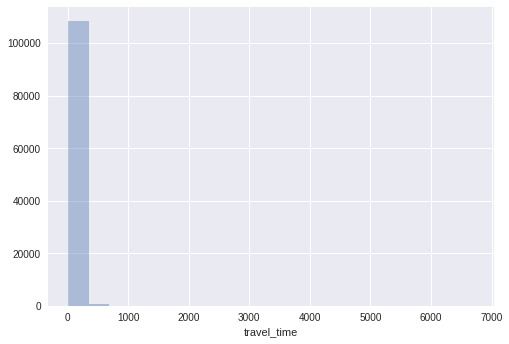

In [9]:
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
sns.distplot(t5.travel_time, bins=20, kde=False)

In [10]:
t5.describe().travel_time
# 发现平均耗时106分钟，最大却有6711分钟

count    109244.000000
mean        106.447486
std          71.761686
min           9.260000
25%          60.230000
50%          93.575000
75%         134.010000
max        6711.110000
Name: travel_time, dtype: float64

In [11]:
## 看看大于500分钟的次数
print t5.shape
print t5[t5.travel_time > 500].shape
print t5[t5.travel_time > 1000].shape
print t5[t5.travel_time > 2000].shape

(109244, 6)
(227, 6)
(34, 6)
(5, 6)


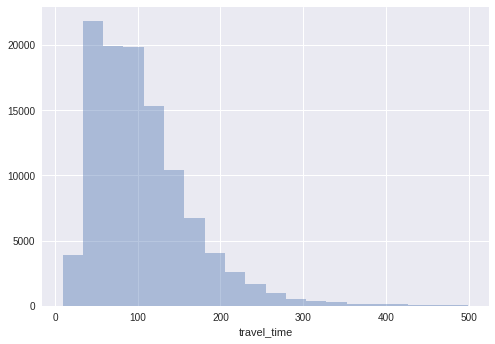

In [12]:
# 1000分钟大约有一天半的时间，应该是outlier ,可能司机在附件的旅馆住了一晚
t5_new = t5[t5.travel_time< 500]
sns.distplot(t5_new.travel_time, bins=20, kde=False)

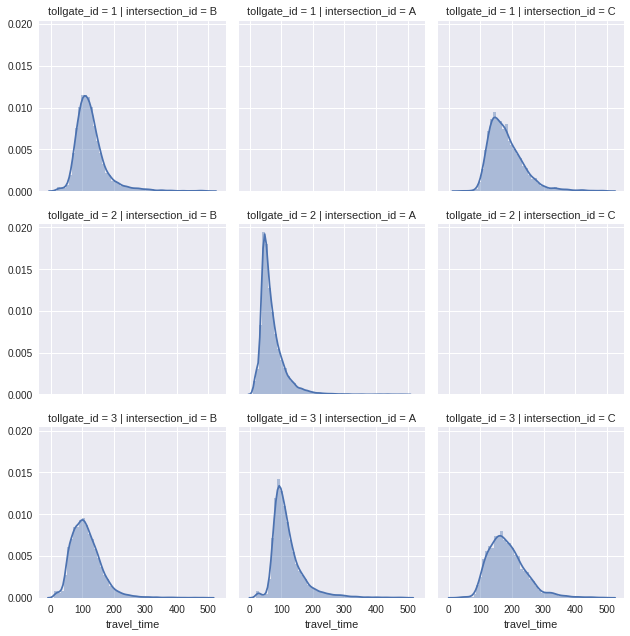

In [13]:
# 不同路线的时间分布

g = sns.FacetGrid(t5_new.loc[:,["travel_time","intersection_id","tollgate_id"]], col="intersection_id",  row="tollgate_id")
g = g.map(sns.distplot, "travel_time")

In [14]:
t7.describe()

,hour,pressure,sea_pressure,wind_direction,wind_speed,temperature,rel_humidity,precipitation
count,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000,862.000000
mean,10.500000,1003.989675,1008.866937,9449.430394,2.302552,27.400348,73.874710,0.212529
std,6.867207,5.449206,5.531463,95832.730719,1.215748,4.869077,15.900988,1.385508
min,0.000000,993.400000,998.200000,0.000000,0.000000,14.100000,25.000000,0.000000
25%,6.000000,1000.000000,1004.800000,81.000000,1.500000,23.800000,63.000000,0.000000
50%,10.500000,1002.750000,1007.550000,188.000000,2.000000,27.400000,75.000000,0.000000
75%,15.000000,1007.000000,1011.900000,295.000000,2.900000,30.800000,87.000000,0.000000
max,21.000000,1018.400000,1023.500000,999017.000000,7.500000,39.400000,98.000000,27.200000


#### 天气数据统计
1. 风向数据有几个在999017，可能是记录出错
2. 降水量大部分为0,最大为27.2

### 数据清洗任务

1. 将t4_new聚合，得到各个路径的路途数据：如路程，途径in out 岔路口数,link数，车道数的均值，最小值
2. 将聚合所得的路程信息按照 intersection_id	tollgate_id加入到t5
3. 按照时间信息将天气merge到t5

In [15]:
# 聚合t4_new
# in out 岔路口数
b1 = t4_new[['intersection_id', 'tollgate_id','cross_in']]\
           .groupby(['intersection_id', 'tollgate_id'])\
            .cross_in.sum().reset_index().rename(columns = {'cross_in':'in_link_cross_count'})
b2 = t4_new[['intersection_id', 'tollgate_id','cross_out']]\
        .groupby(['intersection_id', 'tollgate_id'])\
        .cross_out.sum().reset_index().rename(columns = {'cross_out':'out_link_cross_count'})
road = pd.merge(b1,b2,on =['intersection_id', 'tollgate_id'] ,how='left')

In [16]:
#del b1,b2
# 路程
b1 = t4_new[['intersection_id', 'tollgate_id','length']].groupby(['intersection_id', 'tollgate_id']).length.sum().reset_index()
road = pd.merge(road,b1,on =['intersection_id', 'tollgate_id'] ,how='left')

In [17]:
## 车道数1车道2车道3车道4车道的link数，后期考虑：占总路程的比率
# 各个路径的link总数
b1 = t4_new[['intersection_id', 'tollgate_id']]\
       .groupby(['intersection_id', 'tollgate_id']).size()\
    .reset_index().rename(columns = {0:'link_count'})
road = pd.merge(road,b1,on =['intersection_id', 'tollgate_id'] ,how='left')

In [18]:
# 1,2,3,4车道道路长度
b1 = t4_new[t4_new.lanes== 1][['intersection_id', 'tollgate_id','length']]\
       .groupby(['intersection_id', 'tollgate_id']).length.sum()\
    .reset_index().rename(columns = {'length':'1_length'})
road = pd.merge(road,b1,on =['intersection_id', 'tollgate_id'] ,how='left')
# 2车道数
b1 = t4_new[t4_new.lanes== 2][['intersection_id', 'tollgate_id','length']]\
       .groupby(['intersection_id', 'tollgate_id']).length.sum()\
    .reset_index().rename(columns = {'length':'2_length'})
road = pd.merge(road,b1,on =['intersection_id', 'tollgate_id'] ,how='left')
# 3车道数
b1 = t4_new[t4_new.lanes== 3][['intersection_id', 'tollgate_id','length']]\
       .groupby(['intersection_id', 'tollgate_id']).length.sum()\
    .reset_index().rename(columns = {'length':'3_length'})
road = pd.merge(road,b1,on =['intersection_id', 'tollgate_id'] ,how='left')
# 4车道数
b1 = t4_new[t4_new.lanes== 4][['intersection_id', 'tollgate_id','length']]\
       .groupby(['intersection_id', 'tollgate_id']).length.sum()\
    .reset_index().rename(columns = {'length':'4_length'})
road = pd.merge(road,b1,on =['intersection_id', 'tollgate_id'] ,how='left')


In [19]:
## 1,2,3,4车道link数
b1 = t4_new[t4_new.lanes== 1][['intersection_id', 'tollgate_id']]\
       .groupby(['intersection_id', 'tollgate_id']).size()\
    .reset_index().rename(columns = {0:'1_count'})
road = pd.merge(road,b1,on =['intersection_id', 'tollgate_id'] ,how='left')
# 2车道数
b1 = t4_new[t4_new.lanes== 2][['intersection_id', 'tollgate_id']]\
       .groupby(['intersection_id', 'tollgate_id']).size()\
    .reset_index().rename(columns = {0:'2_count'})
road = pd.merge(road,b1,on =['intersection_id', 'tollgate_id'] ,how='left')
# 3车道数
b1 = t4_new[t4_new.lanes== 3][['intersection_id', 'tollgate_id']]\
       .groupby(['intersection_id', 'tollgate_id']).size()\
    .reset_index().rename(columns = {0:'3_count'})
road = pd.merge(road,b1,on =['intersection_id', 'tollgate_id'] ,how='left')
# 4车道数
b1 = t4_new[t4_new.lanes== 4][['intersection_id', 'tollgate_id']]\
       .groupby(['intersection_id', 'tollgate_id']).size()\
    .reset_index().rename(columns = {0:'4_count'})
road = pd.merge(road,b1,on =['intersection_id', 'tollgate_id'] ,how='left')

road.fillna(0,inplace=True)


In [20]:
# 按照时间窗口重组数据: http://stackoverflow.com/questions/36914892/python-how-to-group-pandas-data-frame-in-a-certain-time-window
t5['starting_time'] =  pd.to_datetime(t5['starting_time'] , format='%Y-%m-%d %H:%M:%S')
t5 = t5.set_index(['starting_time'])
b1 = t5.groupby([pd.TimeGrouper('20Min'), 'intersection_id', 'tollgate_id']).size()\
       .reset_index().rename(columns = {0:'vehicle_count'})
b2 = t5.groupby([pd.TimeGrouper('20Min'), 'intersection_id', 'tollgate_id']).travel_time.mean()\
       .reset_index().rename(columns = {'travel_time':'avg_travel_time'})


In [21]:
t5_new = pd.merge(b1,b2,on = ['starting_time','intersection_id', 'tollgate_id'])

In [22]:
t5_new.rename(columns = {'starting_time':'time_window'},inplace=True)

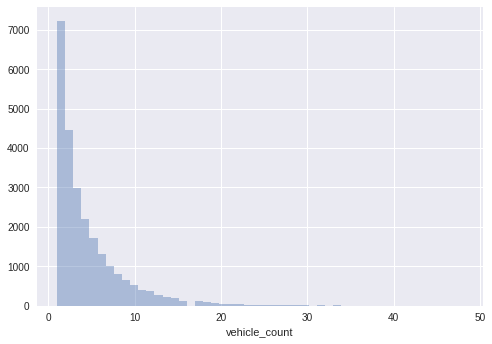

In [23]:
sns.distplot(t5_new.vehicle_count, bins=50, kde=False)

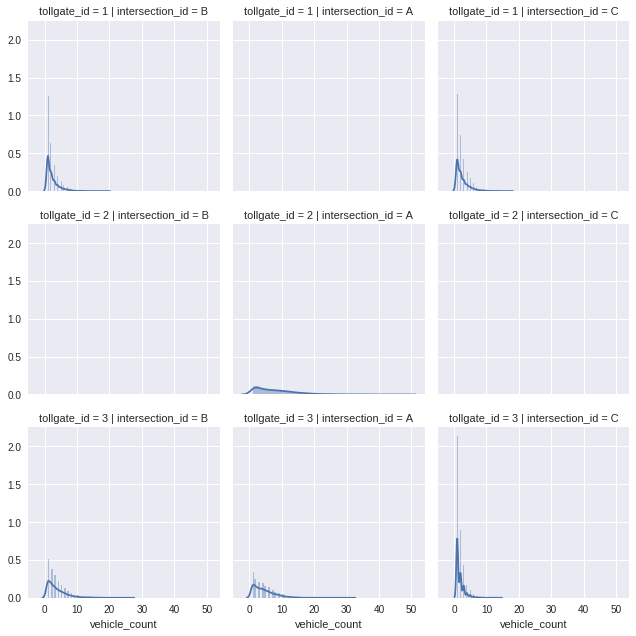

In [24]:
## 各条路线20分钟出发车辆数分布
g = sns.FacetGrid(t5_new.loc[:,["vehicle_count","intersection_id","tollgate_id"]], col="intersection_id",  row="tollgate_id")
g = g.map(sns.distplot, "vehicle_count")


In [25]:
t5, t5_new = t5_new,t5
del t5_new

In [28]:
# 给t5提取新列date hour ,以便merge数据
#ref: http://stackoverflow.com/questions/25789445/pandas-make-new-column-from-string-slice-of-another-column
t5['hour'] = t5.time_window.dt.hour.astype(int)
# 以备后续
t5['hour_to_use'] = t5['hour']
t5['date'] = t5.time_window.dt.date.astype(str)

In [29]:
# 将 hour调到range(0,24,3)
for i, row in t5.iterrows():
    if row['hour'] in [23,0,1]: t5.loc[i, "hour"] = 0
    elif row['hour'] in [2,3,4]: t5.loc[i, "hour"] = 3 
    elif row['hour'] in [5,6,7]: t5.loc[i, "hour"] = 6         
    elif row['hour'] in [8,9,10]: t5.loc[i, "hour"] = 9         
    elif row['hour'] in [11,12,13]: t5.loc[i, "hour"] = 12         
    elif row['hour'] in [14,15,16]: t5.loc[i, "hour"] = 15         
    elif row['hour'] in [17,18,19]: t5.loc[i, "hour"] = 18         
    elif row['hour'] in [20,21,22]: t5.loc[i, "hour"] = 21         
t5.head()        
        

,time_window,intersection_id,tollgate_id,vehicle_count,avg_travel_time,hour,hour_to_use,date
0,2016-07-19 00:00:00,B,3,1,70.85,0,0,2016-07-19
1,2016-07-19 00:20:00,A,2,1,58.05,0,0,2016-07-19
2,2016-07-19 00:20:00,B,1,1,79.76,0,0,2016-07-19
3,2016-07-19 00:20:00,B,3,1,148.79,0,0,2016-07-19
4,2016-07-19 00:40:00,B,1,1,137.98,0,0,2016-07-19


In [30]:
# 将天气数据，道路数据与t5结合
t5 = pd.merge(t5,road,on =['intersection_id', 'tollgate_id'] ,how='left')
# 统一数据类型

t7['hour'] = t7['hour'].astype(int)
t7['date'] = pd.to_datetime(t7['date'], format='%Y-%m-%d')
t5['hour'] = t5['hour'].astype(int)
t5['date'] = pd.to_datetime(t5['date'], format='%Y-%m-%d')

t5 = pd.merge(t5,t7,on =['date', 'hour'] ,how='left')

In [32]:
t5[t5.sea_pressure.isnull()].shape

(376, 27)

In [26]:
t5.shape

(109244, 28)

## 有大概一千多数据没有天气数据

In [33]:
# 增加星期几
t5['weekday'] = t5.time_window.dt.weekday

In [34]:
weeks = pd.get_dummies(t5['weekday'],prefix='weekday_')
t5 = pd.concat([t5,weeks], axis=1)

t5.head()

,time_window,intersection_id,tollgate_id,vehicle_count,avg_travel_time,hour,hour_to_use,date,in_link_cross_count,out_link_cross_count,...,rel_humidity,precipitation,weekday,weekday__0,weekday__1,weekday__2,weekday__3,weekday__4,weekday__5,weekday__6
0,2016-07-19 00:00:00,B,3,1,70.85,0,0,2016-07-19,2,1,...,81.0,0.0,1,0,1,0,0,0,0,0
1,2016-07-19 00:20:00,A,2,1,58.05,0,0,2016-07-19,0,1,...,81.0,0.0,1,0,1,0,0,0,0,0
2,2016-07-19 00:20:00,B,1,1,79.76,0,0,2016-07-19,2,1,...,81.0,0.0,1,0,1,0,0,0,0,0
3,2016-07-19 00:20:00,B,3,1,148.79,0,0,2016-07-19,2,1,...,81.0,0.0,1,0,1,0,0,0,0,0
4,2016-07-19 00:40:00,B,1,1,137.98,0,0,2016-07-19,2,1,...,81.0,0.0,1,0,1,0,0,0,0,0


In [36]:
# 是否假期
from datetime import datetime
def str_to_dtime(string):
    dtime = datetime.strptime(string, "%Y-%m-%d")
    return dtime
# 中秋国庆假期
start1 = datetime(2016, 9, 15)
end1 = datetime(2016, 9, 17)
start2 = datetime(2016, 10, 1)
end2 = datetime(2016, 10, 7)
rng = pd.date_range(start1, end1).append(pd.date_range(start2, end2))


In [37]:
for i, row in t5.iterrows():
    if row['date'] in rng : t5.loc[i, "holoday"] = 1


In [38]:
t5.holoday.sum()

3341.0

In [39]:
## 增加几点钟信息
hours = pd.get_dummies(t5['hour_to_use'],prefix='hour_')
t5 = pd.concat([t5,hours], axis=1)


In [43]:
t5.drop(['hour','hour_to_use','date'],inplace= True,axis=1)

In [44]:
t5.head()

,time_window,intersection_id,tollgate_id,vehicle_count,avg_travel_time,in_link_cross_count,out_link_cross_count,length,link_count,1_length,...,hour__14,hour__15,hour__16,hour__17,hour__18,hour__19,hour__20,hour__21,hour__22,hour__23
0,2016-07-19 00:00:00,B,3,1,70.85,2,1,477,5,255,...,0,0,0,0,0,0,0,0,0,0
1,2016-07-19 00:20:00,A,2,1,58.05,0,1,384,6,142,...,0,0,0,0,0,0,0,0,0,0
2,2016-07-19 00:20:00,B,1,1,79.76,2,1,821,9,275,...,0,0,0,0,0,0,0,0,0,0
3,2016-07-19 00:20:00,B,3,1,148.79,2,1,477,5,255,...,0,0,0,0,0,0,0,0,0,0
4,2016-07-19 00:40:00,B,1,1,137.98,2,1,821,9,275,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# 保存数据
t5.to_pickle('dataSets/training/cleanedtask1data.pkl')

In [49]:
# 
# 按照时间窗口重组数据: http://stackoverflow.com/questions/36914892/python-how-to-group-pandas-data-frame-in-a-certain-time-window
t6['time'] =  pd.to_datetime(t6['time'] , format='%Y-%m-%d %H:%M:%S')
a1 = 
t6 = t6.set_index(['time'])
b1 = t6.groupby([pd.TimeGrouper('20Min'), 'directon', 'tollgate_id']).size()\
       .reset_index().rename(columns = {0:'vehicle_count'})
b2 = t5.groupby([pd.TimeGrouper('20Min'), 'intersection_id', 'tollgate_id']).travel_time.mean()\
       .reset_index().rename(columns = {'travel_time':'avg_travel_time'})

,time,tollgate_id,direction,vehicle_model,has_etc,vehicle_type
0,2016-09-19 23:09:25,2,0,1,0,NaN
1,2016-09-19 23:11:53,2,0,1,0,NaN
2,2016-09-19 23:13:54,2,0,1,0,NaN
3,2016-09-19 23:17:48,1,0,1,1,NaN
4,2016-09-19 23:16:07,2,0,1,0,NaN


In [50]:
rng

DatetimeIndex(['2016-09-15', '2016-09-16', '2016-09-17', '2016-10-01',
               '2016-10-02', '2016-10-03', '2016-10-04', '2016-10-05',
               '2016-10-06', '2016-10-07'],
              dtype='datetime64[ns]', freq=None)

每条路径in_top =2 和out_top =2 岔路口数,


路程,

路途的路径宽度: 1车道2车道3车道4车道的link数，1车道2车道3车道4车道的长度

是否过节,国庆节:'2016-10-01-2016-10-07',中秋节''2016-09-15-2016-09-17''

对于缺失天气的填充方案